<a href="https://colab.research.google.com/github/Saiharshi1/ores5160-2025/blob/main/Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
import numpy as np

# 1. Load your master Patient list
# We need this to know which IDs are valid (1 to 20000)
df_patients = pd.read_csv('Patient.csv')
valid_ids = df_patients['PatientID'].unique()

# 2. Load the raw encounters file
# This file currently has useless IDs like "10004235"
df_encounters = pd.read_csv('raw_encounters.csv')



In [27]:
# Fixing the issue
# We overwrite 'subject_id' with random selections from our valid_ids list.
# This guarantees that every encounter now belongs to a real patient in your system.
df_encounters['subject_id'] = np.random.choice(valid_ids, size=len(df_encounters))

# 3. Create the 3 Source Files for your Project
# Now that the data is linked, we split it into the formats

# File A: CSV (The Main Clinical Data)
# We take the majority of rows for the main CSV
df_encounters_csv = df_encounters.iloc[50:].copy()
df_encounters_csv.to_csv('hospital_visits.csv', index=False)
print("Generated 'hospital_visits.csv' (CSV Format)")

# File B: JSON (The "Legacy System" Dump)
# We take the first 20 rows and save as JSON
df_encounters_json = df_encounters.head(20).copy()
# Add some "nested" complexity
df_encounters_json['hospital_metadata'] = df_encounters_json.apply(
    lambda x: {'ward': 'General', 'bed': np.random.randint(1, 100)}, axis=1
)
df_encounters_json.to_json('legacy_system_dump.json', orient='records', indent=4)
print("Generated 'legacy_system_dump.json' (JSON Format)")

# File C: HTML (The "Scraped Report")
# We take a slice of data and wrap it in HTML tags
df_html_subset = df_encounters[['subject_id', 'admittime', 'insurance']].iloc[20:50]
html_content = f"""
<html>
<head><title>Daily Admission Report</title></head>
<body>
    <h2>Confidential Admissions Log</h2>
    {df_html_subset.to_html(index=False)}
    <p>Report Generated: {pd.Timestamp.now()}</p>
</body>
</html>
"""
with open('admissions_report.html', 'w') as f:
    f.write(html_content)
print("Generated 'admissions_report.html' (HTML Format)")

Generated 'hospital_visits.csv' (CSV Format)
Generated 'legacy_system_dump.json' (JSON Format)
Generated 'admissions_report.html' (HTML Format)


In [28]:
import pandas as pd
import numpy as np
import json
import sqlite3
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- 0. SETUP LOGGING ---
logging.basicConfig(filename='pipeline.log', level=logging.INFO, force=True)
print("Starting End-to-End Pipeline")

# --- 1. DATA CHECK & GENERATION (The "Fixer")
# We check if the processed files exist. If not, we generate them from Patient.csv and raw_encounters.csv
if not os.path.exists('hospital_visits.csv') or not os.path.exists('legacy_system_dump.json'):
    print(" Input files missing. Generating them now")
    try:
        # Load Raw Data
        df_patients = pd.read_csv('Patient.csv')
        df_encounters = pd.read_csv('raw_encounters.csv')
        valid_ids = df_patients['PatientID'].unique()

        # Fix Linkage (Overwrite IDs)
        df_encounters['subject_id'] = np.random.choice(valid_ids, size=len(df_encounters))

        # Create CSV Input (System A)
        df_encounters.iloc[50:].to_csv('hospital_visits.csv', index=False)

        # Create JSON Input (System B)
        # Handle datetime conversion for JSON serialization
        json_data = df_encounters.head(20).copy()
        # Convert timestamps to string to avoid JSON serialization error
        if 'admittime' in json_data.columns:
            json_data['admittime'] = json_data['admittime'].astype(str)

        json_data.to_json('legacy_system_dump.json', orient='records', indent=4)

        # Create HTML Input (System C)
        html_data = df_encounters[['subject_id', 'admittime', 'insurance']].iloc[20:50]
        html_content = f"<html><table>{html_data.to_html(index=False)}</table></html>"
        with open('admissions_report.html', 'w') as f:
            f.write(html_content)

        print("Data Generation Complete.")
    except Exception as e:
        print(f" CRITICAL ERROR during Data Gen: {e}")
        # Stop execution if we can't generate data
        raise e



Starting End-to-End Pipeline


In [29]:
############### --- 2. INGESTION ---##############
print("Ingesting Data")
try:
    # Load Dimension
    df_pat = pd.read_csv('Patient.csv')
    df_pat.columns = [c.lower() for c in df_pat.columns] # Standardize headers

    # Load Facts
    df_visits = pd.read_csv('hospital_visits.csv')

    with open('legacy_system_dump.json', 'r') as f:
        df_json = pd.json_normalize(json.load(f))

    dfs_html = pd.read_html('admissions_report.html')
    df_html = dfs_html[0]

except Exception as e:
    print(f" Ingestion Failed: {e}")
    raise e



Ingesting Data


In [30]:
##################### --- 3. CLEANING & TRANSFORMATION ---###################
print(" Cleaning Data")
# Standardize Columns
df_visits = df_visits[['subject_id', 'admittime', 'insurance', 'admission_type']].rename(columns={'subject_id': 'patient_id', 'admittime': 'encounter_date'})
df_visits['source'] = 'CSV'

df_json = df_json[['subject_id', 'admittime', 'insurance', 'admission_type']].rename(columns={'subject_id': 'patient_id', 'admittime': 'encounter_date'})
df_json['source'] = 'JSON'

df_html = df_html[['subject_id', 'admittime', 'insurance']].rename(columns={'subject_id': 'patient_id', 'admittime': 'encounter_date'})
df_html['admission_type'] = 'Unknown'
df_html['source'] = 'HTML'

# Merge
fact_encounters = pd.concat([df_visits, df_json, df_html], ignore_index=True)
fact_encounters['encounter_date'] = pd.to_datetime(fact_encounters['encounter_date'])



 Cleaning Data


In [31]:
#############--- 4. LOAD TO SQL ---################
print("Loading to Database")
conn = sqlite3.connect('health_warehouse.db')
df_pat.to_sql('dim_patients', conn, if_exists='replace', index=False)
fact_encounters.to_sql('fact_encounters', conn, if_exists='replace', index=False)
conn.close()
print("Database Built Successfully!")



Loading to Database
Database Built Successfully!


Generating Visuals

-Pipeline Audit
  source  count
0    CSV    225
1   HTML     30
2   JSON     20


/tmp/ipython-input-932556451.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_audit, x='source', y='count', palette='viridis')


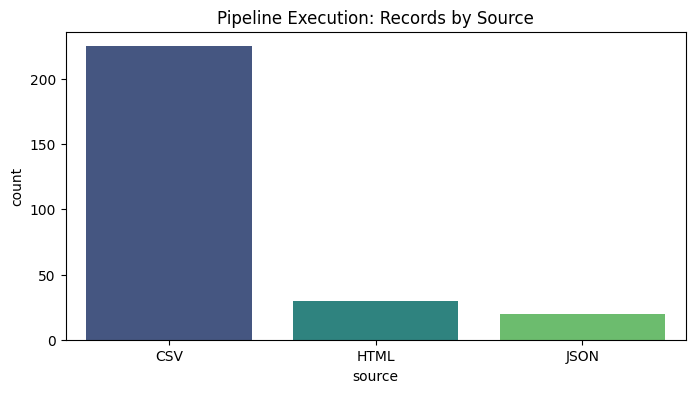

Visuals Generated.


In [32]:
##################--- 5. VISUALIZATION ---############
print("Generating Visuals")
conn = sqlite3.connect('health_warehouse.db') # Reconnect
try:
    # Audit Query
    df_audit = pd.read_sql("SELECT source, COUNT(*) as count FROM fact_encounters GROUP BY source", conn)
    print("\n-Pipeline Audit")
    print(df_audit)

    # Plot
    plt.figure(figsize=(8, 4))
    sns.barplot(data=df_audit, x='source', y='count', palette='viridis')
    plt.title('Pipeline Execution: Records by Source')
    plt.savefig('pipeline_audit.png')
    plt.show()
    print("Visuals Generated.")

except Exception as e:
    print(f"Visualization Failed: {e}")
finally:
    conn.close()

In [33]:
import pandas as pd
import json

print("STEP 2: VERIFYING INGESTION")

# --- 1. Verify CSV Ingestion ---
try:
    df_visits = pd.read_csv('hospital_visits.csv')
    print(f"\n-CSV Loaded Successfully: {len(df_visits)} rows")
    print("Columns:", df_visits.columns.tolist())
    print(df_visits.head(2)) # Show actual data
except Exception as e:
    print(f"CSV Failed: {e}")



STEP 2: VERIFYING INGESTION

-CSV Loaded Successfully: 225 rows
Columns: ['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'admit_provider_id', 'admission_location', 'discharge_location', 'insurance', 'language', 'marital_status', 'race', 'edregtime', 'edouttime', 'hospital_expire_flag']
   subject_id   hadm_id         admittime        dischtime deathtime  \
0       17040  25933959  12/29/2147 19:36   1/9/2148 17:38       NaN   
1        4691  23300884   3/19/2125 16:58  3/28/2125 13:37       NaN   

  admission_type admit_provider_id  admission_location  \
0       ELECTIVE            P43BTJ  PHYSICIAN REFERRAL   
1       EW EMER.            P76K54      EMERGENCY ROOM   

         discharge_location insurance language marital_status  \
0  SKILLED NURSING FACILITY     Other  ENGLISH       DIVORCED   
1          HOME HEALTH CARE     Other  ENGLISH         SINGLE   

                     race        edregtime        edouttime  \
0                   WHITE  

In [34]:
# --- 2. Verify JSON Ingestion ---
try:
    with open('legacy_system_dump.json', 'r') as f:
        data = json.load(f)
        # Use json_normalize to flatten it
        df_json = pd.json_normalize(data)

    print(f"\n-JSON Loaded Successfully: {len(df_json)} rows")
    print("   Columns:", df_json.columns.tolist())
    print(df_json.head(2))
except Exception as e:
    print(f"JSON Failed: {e}")




-JSON Loaded Successfully: 20 rows
   Columns: ['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'admit_provider_id', 'admission_location', 'discharge_location', 'insurance', 'language', 'marital_status', 'race', 'edregtime', 'edouttime', 'hospital_expire_flag', 'hospital_metadata.ward', 'hospital_metadata.bed']
   subject_id   hadm_id        admittime        dischtime deathtime  \
0         942  24181354  2/24/2196 14:38   3/4/2196 14:02      None   
1       17454  25926192  9/17/2153 17:08  9/25/2153 13:20      None   

  admission_type admit_provider_id      admission_location  \
0         URGENT            P03YMR  TRANSFER FROM HOSPITAL   
1         URGENT            P41R5N  TRANSFER FROM HOSPITAL   

         discharge_location insurance language marital_status  \
0  SKILLED NURSING FACILITY  Medicaid  ENGLISH         SINGLE   
1          HOME HEALTH CARE  Medicaid        ?        MARRIED   

                             race        edregtime     

In [35]:
# --- 3. Verify HTML Ingestion ---
try:
    # read_html returns a list of tables, we want the first one [0]
    dfs = pd.read_html('admissions_report.html')
    df_html = dfs[0]

    print(f"\n-HTML Loaded Successfully: {len(df_html)} rows")
    print("   Columns:", df_html.columns.tolist())
    print(df_html.head(2))
except Exception as e:
    print(f"HTML Failed: {e}")


-HTML Loaded Successfully: 30 rows
   Columns: ['subject_id', 'admittime', 'insurance']
   subject_id        admittime insurance
0        6289  12/8/2145 19:47     Other
1        7573  8/27/2142 21:05     Other


In [36]:
import pandas as pd

print("STEP 3: CLEANING & TRANSFORMATION")

# --- 1. Clean Patient Data (Dimension) ---
df_pat = pd.read_csv('Patient.csv')
df_pat.columns = [c.lower() for c in df_pat.columns] # Governance: Standardize headers

# Validation: Fix Date Types
df_pat['dateofbirth'] = pd.to_datetime(df_pat['dateofbirth'], errors='coerce')

# Validation: The "Vampire Check"
# We filter out patients born before 1900
original_count = len(df_pat)
df_pat = df_pat[df_pat['dateofbirth'] > '1900-01-01']
dropped_count = original_count - len(df_pat)
print(f"Patient Table Cleaned: Dropped {dropped_count} invalid records (Vampires).")

STEP 3: CLEANING & TRANSFORMATION
Patient Table Cleaned: Dropped 2147 invalid records (Vampires).


In [37]:
# --- 2. Standardize & Merge Encounters (Fact) ---
# We need to make the columns match perfectly before merging.

# A. Prepare CSV
df_visits_clean = df_visits[['subject_id', 'admittime', 'insurance', 'admission_type']].copy()
df_visits_clean.rename(columns={'subject_id': 'patient_id', 'admittime': 'encounter_date'}, inplace=True)
df_visits_clean['source_system'] = 'CSV'

# B. Prepare JSON
df_json_clean = df_json[['subject_id', 'admittime', 'insurance', 'admission_type']].copy()
df_json_clean.rename(columns={'subject_id': 'patient_id', 'admittime': 'encounter_date'}, inplace=True)
df_json_clean['source_system'] = 'JSON'

# C. Prepare HTML
# HTML usually lacks columns, so we match what we have and fill the rest
df_html_clean = df_html[['subject_id', 'admittime', 'insurance']].copy()
df_html_clean.rename(columns={'subject_id': 'patient_id', 'admittime': 'encounter_date'}, inplace=True)
df_html_clean['admission_type'] = 'Unknown' # Handle missing schema
df_html_clean['source_system'] = 'HTML'

# D. The Merge (Rubric Item 3: Reshaping/Integration)
fact_encounters = pd.concat([df_visits_clean, df_json_clean, df_html_clean], ignore_index=True)

# Final Type Casting
fact_encounters['encounter_date'] = pd.to_datetime(fact_encounters['encounter_date'])

print(f"Transformation Complete. Combined Registry Size: {len(fact_encounters)} rows.")
print("Sample Data:")
print(fact_encounters.head(5))

Transformation Complete. Combined Registry Size: 275 rows.
Sample Data:
   patient_id      encounter_date insurance admission_type source_system
0       17040 2147-12-29 19:36:00     Other       ELECTIVE           CSV
1        4691 2125-03-19 16:58:00     Other       EW EMER.           CSV
2         282 2200-09-17 22:53:00     Other       EW EMER.           CSV
3        6209 2201-07-07 18:15:00     Other       EW EMER.           CSV
4       13029 2167-11-07 19:05:00     Other       EW EMER.           CSV


In [38]:
import sqlite3

print("STEP 4: LOADING TO SQL WAREHOUSE")

# --- 1. Connect to Database ---
# This creates the file 'health_warehouse.db' if it doesn't exist
conn = sqlite3.connect('health_warehouse.db')
cursor = conn.cursor()

# --- 2. Load Tables ---
try:
    # Load Dimension: Patients
    # if_exists='replace' drops the table if we run this cell again (good for testing)
    df_pat.to_sql('dim_patients', conn, if_exists='replace', index=False)
    print("Table 'dim_patients' created successfully.")

    # Load Fact: Encounters
    fact_encounters.to_sql('fact_encounters', conn, if_exists='replace', index=False)
    print("Table 'fact_encounters' created successfully.")

    # --- 3. Verify Loading (The "Select Count" Test) ---
    # We query the database directly to make sure it's not empty
    patient_count = pd.read_sql("SELECT COUNT(*) FROM dim_patients", conn).iloc[0,0]
    encounter_count = pd.read_sql("SELECT COUNT(*) FROM fact_encounters", conn).iloc[0,0]

    print(f"\n- WAREHOUSE STATUS:")
    print(f"- Patients Stored: {patient_count}")
    print(f"- Encounters Stored: {encounter_count}")

    # Optional: Check the Schema
    print("\n   - Schema for 'fact_encounters':")
    for row in cursor.execute("PRAGMA table_info(fact_encounters)").fetchall():
        print(f"     {row[1]} ({row[2]})")

except Exception as e:
    print(f"Database Load Failed: {e}")

finally:
    conn.close()

STEP 4: LOADING TO SQL WAREHOUSE
Table 'dim_patients' created successfully.
Table 'fact_encounters' created successfully.

- WAREHOUSE STATUS:
- Patients Stored: 17853
- Encounters Stored: 275

   - Schema for 'fact_encounters':
     patient_id (INTEGER)
     encounter_date (TIMESTAMP)
     insurance (TEXT)
     admission_type (TEXT)
     source_system (TEXT)


STEP 5: VISUALIZATION & REPORTING


/tmp/ipython-input-1435614696.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_audit, x='source_system', y='count', palette='viridis')


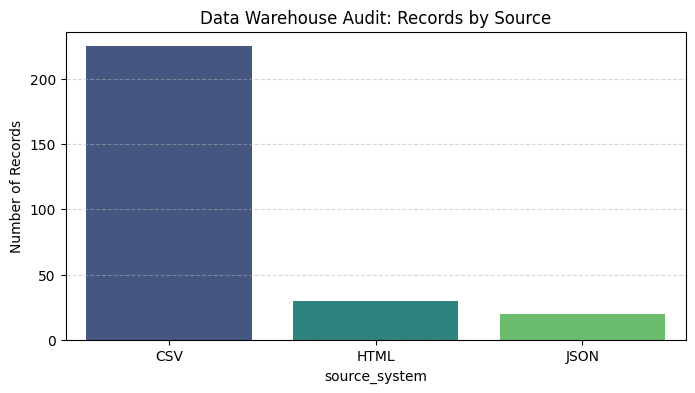

Generated 'viz_audit.png' (Lineage Audit)


/tmp/ipython-input-1435614696.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_insurance, y='insurance', x='count', palette='magma')


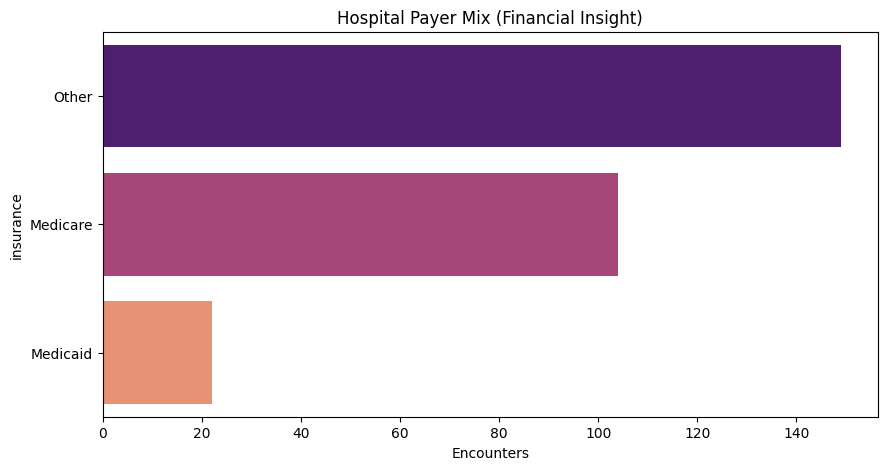

Generated 'viz_insurance.png' (Business Insight)


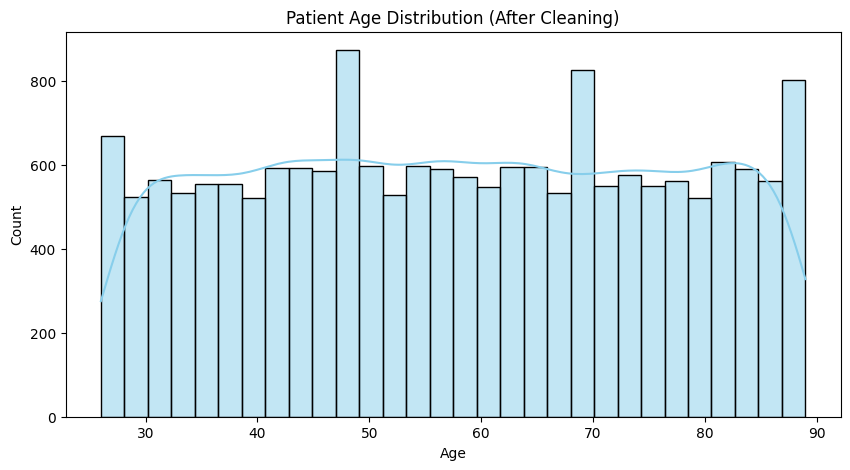

Generated 'viz_age.png' (Demographics)

-ALL STEPS COMPLETED.


In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3

print("STEP 5: VISUALIZATION & REPORTING")

# --- 1. Connect to the Warehouse ---
conn = sqlite3.connect('health_warehouse.db')

# --- 2. VIZ A: Data Lineage Audit (Governance) ---
# Query: Count records by source system
df_audit = pd.read_sql("SELECT source_system, COUNT(*) as count FROM fact_encounters GROUP BY source_system", conn)

plt.figure(figsize=(8, 4))
sns.barplot(data=df_audit, x='source_system', y='count', palette='viridis')
plt.title('Data Warehouse Audit: Records by Source')
plt.ylabel('Number of Records')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.savefig('viz_audit.png') # Saving to file for your report
plt.show()
print("Generated 'viz_audit.png' (Lineage Audit)")


# --- 3. VIZ B: Payer Mix (Business Insight) ---
# Query: Count records by Insurance type
df_insurance = pd.read_sql("SELECT insurance, COUNT(*) as count FROM fact_encounters GROUP BY insurance", conn)
df_insurance = df_insurance.sort_values('count', ascending=False) # Sort for better chart

plt.figure(figsize=(10, 5))
sns.barplot(data=df_insurance, y='insurance', x='count', palette='magma')
plt.title('Hospital Payer Mix (Financial Insight)')
plt.xlabel('Encounters')
plt.savefig('viz_insurance.png')
plt.show()
print("Generated 'viz_insurance.png' (Business Insight)")


# --- 4. VIZ C: Patient Demographics (EDA) ---
# Query: Get birth dates to calculate age
df_pat = pd.read_sql("SELECT dateofbirth FROM dim_patients", conn)
df_pat['dateofbirth'] = pd.to_datetime(df_pat['dateofbirth'])
# Calculate Age
df_pat['age'] = (pd.Timestamp.now() - df_pat['dateofbirth']).dt.days // 365

plt.figure(figsize=(10, 5))
sns.histplot(df_pat['age'], bins=30, kde=True, color='skyblue')
plt.title('Patient Age Distribution (After Cleaning)')
plt.xlabel('Age')
plt.savefig('viz_age.png')
plt.show()
print("Generated 'viz_age.png' (Demographics)")

conn.close()
print("\n-ALL STEPS COMPLETED.")